# Using the CMI approach to mimic viscoelastic models of Chi Chi postseismic deformation 

## Getting a sense for the output: Make a single pyGMT plot

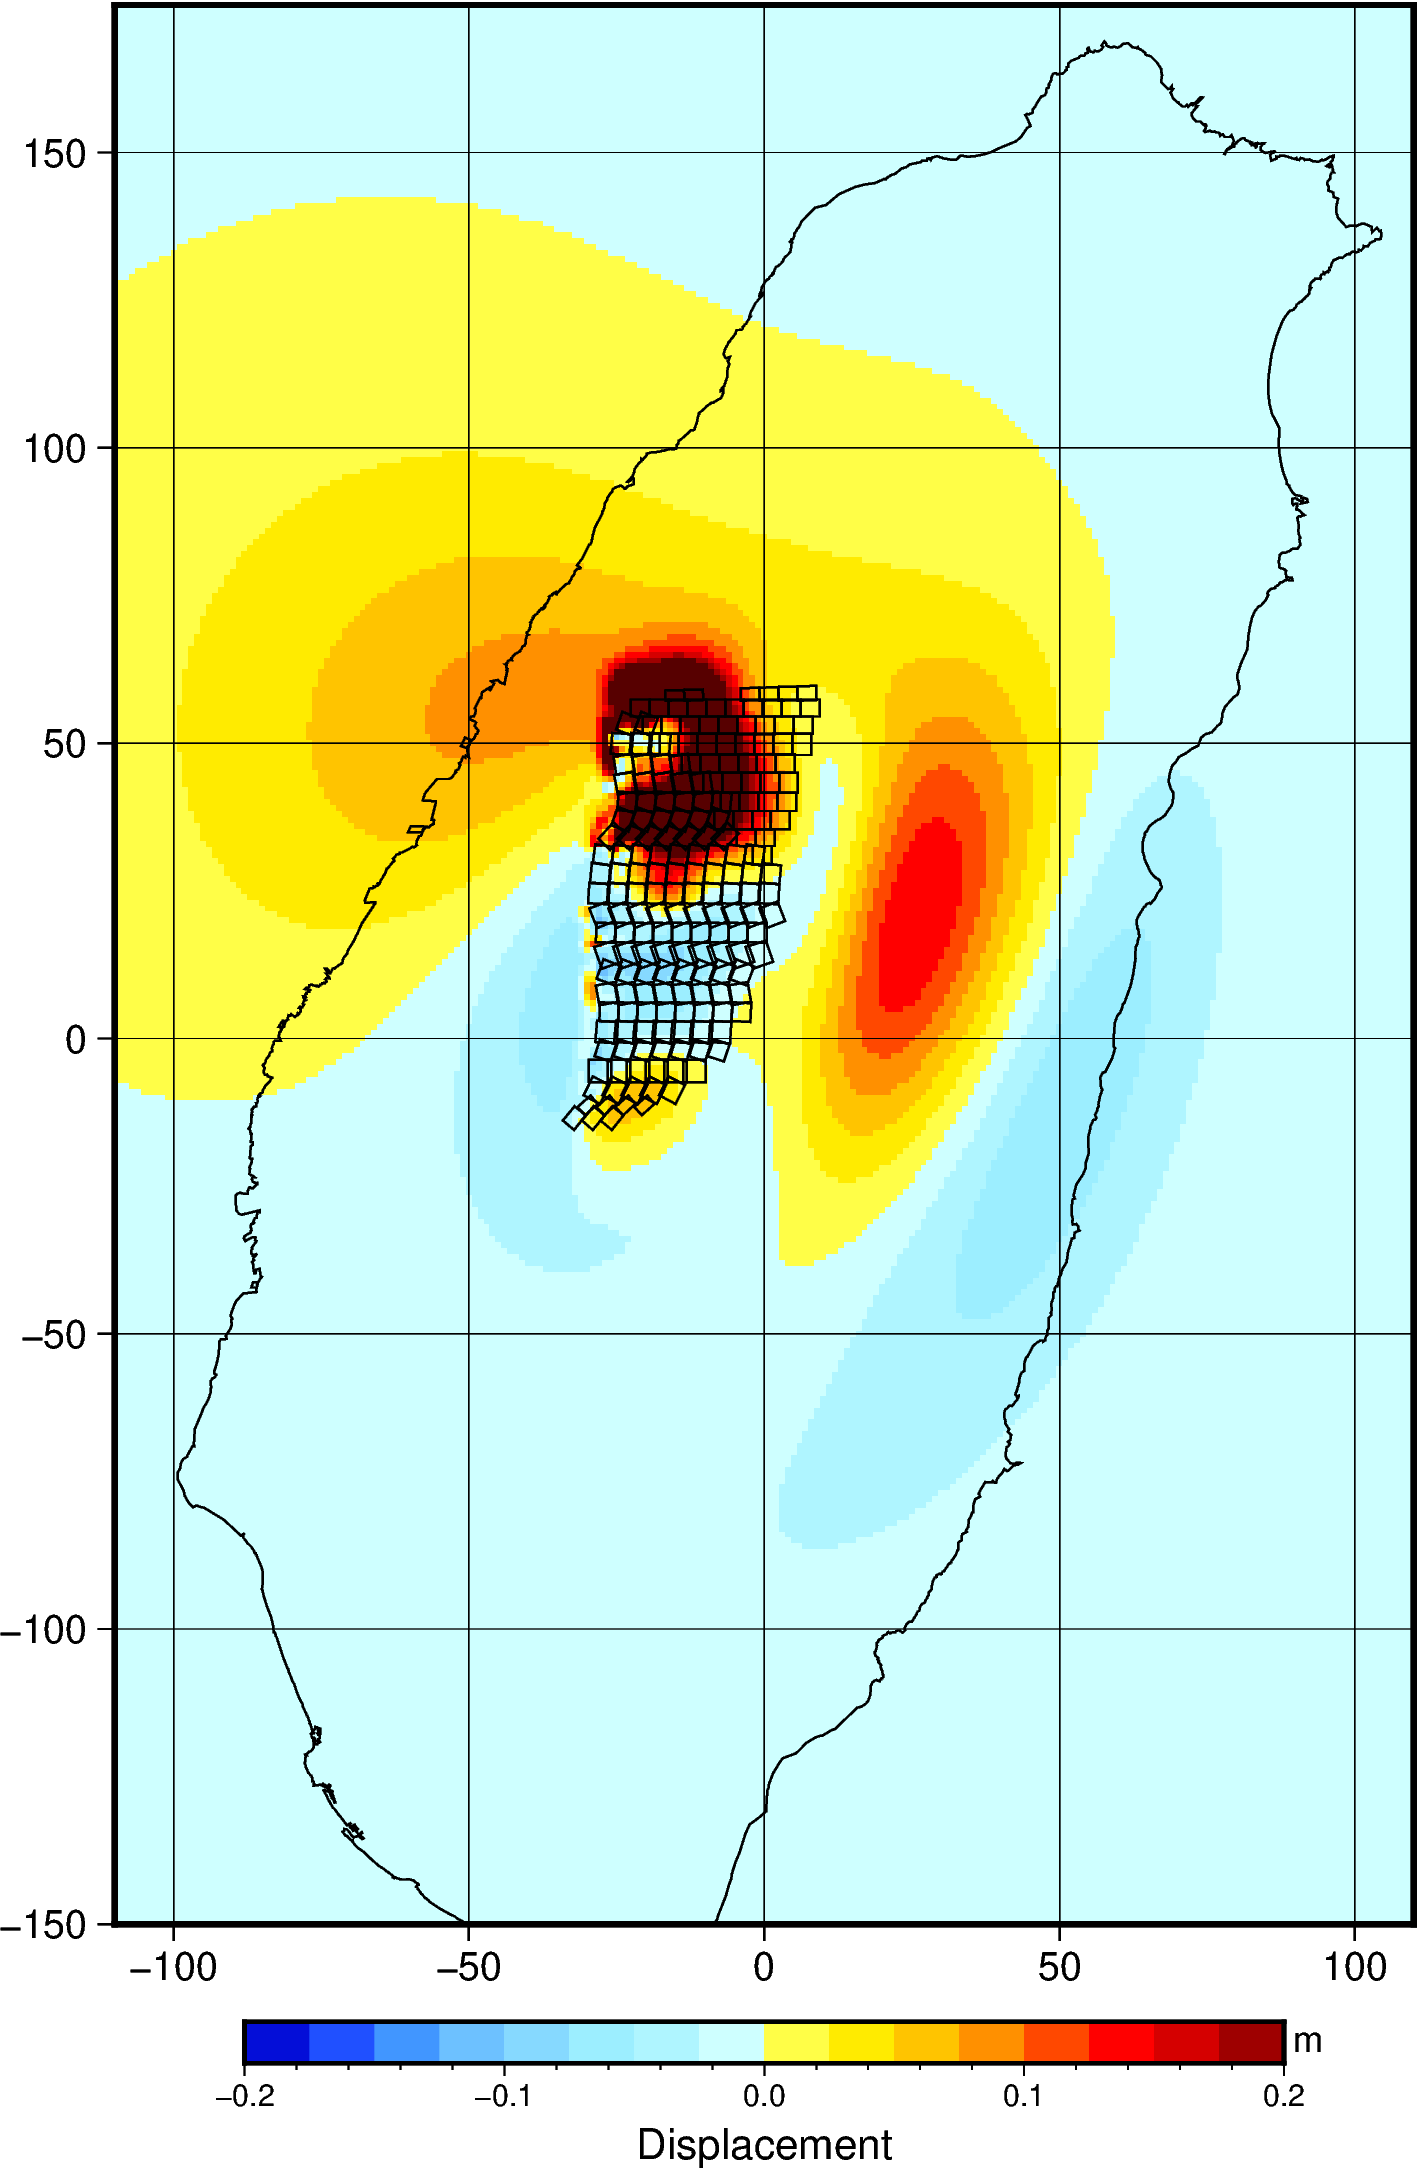

In [1]:
import pygmt
import numpy as np

directory = "/Users/jloveles/Documents/relax/examples/taiwan/coupled"
pathname = directory + "/200-relax-up.grd"
faultname = "/Users/jloveles/Documents/relax/examples/taiwan/coupled/rfaults-001.xy"
coastname = "/Users/jloveles/Documents/relax/examples/taiwan/gmt/twcoasts_km.xyz"
grid = pygmt.load_dataarray(pathname)

# Get z limits from grdinfo
info = pygmt.grdinfo(pathname, nearest_multiple="+a0.1")

fig = pygmt.Figure()
pygmt.makecpt(cmap="panoply", series=[-0.2, 0.2])
fig.grdimage(grid=grid, region=[-110, 110, -150, 175], projection="X11c/16.25c", frame="ag")
fig.colorbar(frame=["x+lDisplacement", "y+lm"])

pygmt.makecpt(cmap="gray", series=[0, 2000])
fig.plot(faultname, close=True, pen="0.5p")
fig.plot(coastname, close=True, pen="0.5p")

fig.show()

# Get coordinates from grid plotted above
gsubset = 10 # Subset of grid points: increment every gsubset points along grid
xg = np.array(grid.x)
yg = np.array(grid.y)
Xg, Yg = np.meshgrid(xg, yg)
obsg = np.array([Xg[0::gsubset, 0::gsubset], Yg[0::gsubset, 0::gsubset], 0*Yg[0::gsubset, 0::gsubset]]).reshape((3, -1)).T.copy()

## Set up triangular dislocation sources

### Horizontal fault at the crust-mantle interface

In [2]:
def tri_horizon(x, y, z, el_size, ztilt=0.01):
    # Makes a simple ~horizon of triangular dislocation elements using Gmsh
    # x, y are 2-element arrays defining horizontal bounds
    # z is a scalar giving depth 
    # el_size gives nominal element size 

    import gmsh
    import meshio
    
    # Mesh construction using Gmsh
    gmsh.initialize()
    # Define points
    gmsh.model.geo.addPoint(x[0], y[0], z+ztilt, el_size, 1)
    gmsh.model.geo.addPoint(x[1], y[0], z-ztilt, el_size, 2)
    gmsh.model.geo.addPoint(x[1], y[1], z-ztilt, el_size, 3)
    gmsh.model.geo.addPoint(x[0], y[1], z+ztilt, el_size, 4)
    # Boundary lines
    gmsh.model.geo.addLine(1, 2, 1)
    gmsh.model.geo.addLine(2, 3, 2)
    gmsh.model.geo.addLine(3, 4, 3)
    gmsh.model.geo.addLine(4, 1, 4)
    # Perimeter
    gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)
    # Surface
    gmsh.model.geo.addPlaneSurface([1], 1)
    gmsh.model.geo.synchronize()
    # Generate and write. Writing a file allows use of meshio, consistent with celeri codes
    gmsh.model.mesh.generate(2)
    gmsh.write("file.msh")
    gmsh.finalize()

    # Read and parse mesh
    mesh = meshio.read("file.msh")
    fault_pts = mesh.points
    fault_tri = meshio.CellBlock("triangle", mesh.get_cells_type("triangle")).data
    return fault_pts, fault_tri

### Source fault for kinematic afterslip (Hsu et al., 2002)

In [ ]:
# Digitized fault corners, from Rousset Figure 7
corners = np.array(((-32.068311195445915, -25.265553869499243), (-25.237191650853887, 54.40060698027315), (27.514231499051235, 49.848254931714735), (19.924098671726753, -30.197268588770868)))
strike = np.arctan2(corners[1, 0]-corners[0, 0], corners[1, 1]-corners[0, 1])

# Approximated, using just SW corner and projecting
strike = np.deg2rad(5)
top_panel_width = 20
top_panel_dip = 30
top_panel_horiz = top_panel_width*np.cos(np.deg2rad(top_panel_dip))
top_panel_bot = top_panel_width*np.sin(np.deg2rad(top_panel_dip))
bot_panel_width = 35
bot_panel_dip = 5
bot_panel_horiz = bot_panel_width*np.cos(np.deg2rad(bot_panel_dip))
bot_panel_bot = bot_panel_width*np.sin(np.deg2rad(bot_panel_dip))
fault_length = 80

# Panel coordinates
top_panel_rect = np.array(((0, 0), (top_panel_horiz, 0), (top_panel_horiz, fault_length), (0, fault_length)))
bot_panel_rect = np.array(((0, 0), (bot_panel_horiz, 0), (bot_panel_horiz, fault_length), (0, fault_length)))

# Rotate by strike
top_panel_rect = np.array((np.cos(strike)*top_panel_rect[:, 0] + np.sin(strike)*top_panel_rect[:, 1], -np.sin(strike)*top_panel_rect[:, 0] + np.cos(strike)*top_panel_rect[:, 1])).T
bot_panel_rect = np.array((np.cos(strike)*bot_panel_rect[:, 0] + np.sin(strike)*bot_panel_rect[:, 1], -np.sin(strike)*bot_panel_rect[:, 0] + np.cos(strike)*bot_panel_rect[:, 1])).T

# Shift by SW corners
top_panel_rect = top_panel_rect + corners[0, :]
bot_panel_rect = bot_panel_rect + top_panel_rect[1, :]

# Add depths
top_panel_rect = np.hstack((top_panel_rect, np.array([[0], [top_panel_bot], [top_panel_bot], [0]])))
bot_panel_rect = np.hstack((bot_panel_rect, top_panel_bot + np.array([[0], [bot_panel_bot], [bot_panel_bot], [0]])))

# Create mesh
if gmsh.isInitialized() == 0:
    gmsh.initialize()
gmsh.option.setNumber("General.Verbosity", 0)    
gmsh.clear()
# Define points
# From top
for i in range(4):
    gmsh.model.geo.addPoint(top_panel_rect[i, 0], top_panel_rect[i, 1], -top_panel_rect[i, 2], 5, i)
# From bottom
gmsh.model.geo.addPoint(bot_panel_rect[1, 0], bot_panel_rect[1, 1], -bot_panel_rect[1, 2], 5, 4)
gmsh.model.geo.addPoint(bot_panel_rect[2, 0], bot_panel_rect[2, 1], -bot_panel_rect[2, 2], 5, 5)
# Define lines
for i in range(3):
    gmsh.model.geo.addLine(i, i+1, i)
# Top edge
gmsh.model.geo.addLine(3, 0, i+1)
# Bottoms
gmsh.model.geo.addLine(1, 4, 5)
gmsh.model.geo.addLine(4, 5, 6)
gmsh.model.geo.addLine(5, 2, 7)
# Define curve loops
gmsh.model.geo.addCurveLoop(list(range(0, 4)), 1)
gmsh.model.geo.addCurveLoop((5, 6, 7, -1), 2)
# Surfaces
gmsh.model.geo.addPlaneSurface([1], 1)
gmsh.model.geo.addPlaneSurface([2], 2)
gmsh.model.geo.synchronize()
gmsh.write('chelungpu.geo_unrolled')
# Generate and write. Writing a file allows use of meshio, consistent with celeri codes
gmsh.model.mesh.generate(2)
gmsh.write("chelungpu.msh")
gmsh.finalize()

plot_outline = False
if plot_outline:
    fig, ax = plt.subplots()
    plt.plot(top_panel_rect[:, 0], top_panel_rect[:, 1])
    plt.plot(bot_panel_rect[:, 0], bot_panel_rect[:, 1])
    ax.axis("equal")

### Source fault for coupled afterslip (Rousset et al., 2012)

## Read postseismic GPS data

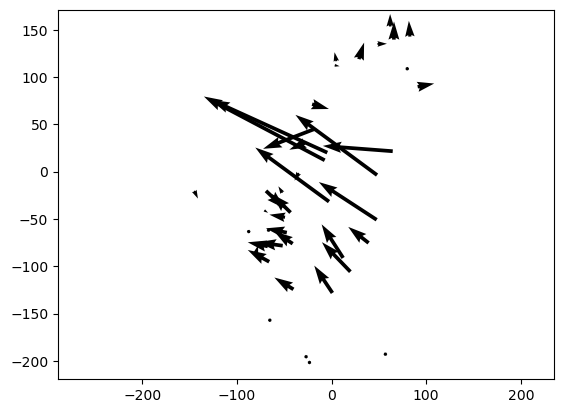

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
colnames = ['y', 'x', 'e', 'n', 'u']
gps = pd.read_table("/Users/jloveles/Documents/relax/examples/taiwan/gps/postseismic_neu_today_km.dat", sep='\s+', header=None, names=colnames)

plot_vectors = False
if plot_vectors:
    fig, ax = plt.subplots()
    ax.quiver(gps.x, gps.y, gps.e, gps.n)
    ax.axis("equal")
    plt.show()

## Define source mesh and horizon

In [4]:
def make_meshes(sourcename, source_el_size, horiz_x, horiz_y, horiz_z, horiz_el_size, ztilt):
    
    import addict
    import scipy.spatial
    import scipy.interpolate
    import gmsh
    import meshio
    import pandas as pd

    colnames = ['no','slip','ys','xs','zs','length','width','strike','dip','rake']
    faults = pd.read_table(sourcename, sep='\s+', header=None, names=colnames)

    # Find convex hull around x, y points of faults
    faultpoints = faults[["xs", "ys"]].to_numpy() 
    hull = scipy.spatial.ConvexHull(faultpoints)

    # Mesh convex hull as a network of TDEs

    gmsh.initialize()
    gmsh.clear()
    # Define points
    for i in range(len(hull.vertices)):
        gmsh.model.geo.addPoint(faultpoints[hull.vertices[i],0], faultpoints[hull.vertices[i],1], 0, source_el_size, i)
    # Define lines
    for i in range(len(hull.vertices)-1):
        gmsh.model.geo.addLine(i, i+1, i)
    gmsh.model.geo.addLine(i+1, 0, i+1)
    # Define curve loop
    gmsh.model.geo.addCurveLoop(list(range(0, i+2)), 1)
    # Surface
    gmsh.model.geo.addPlaneSurface([1], 1)
    gmsh.model.geo.synchronize()
    # Generate and write. Writing a file allows use of meshio, consistent with celeri codes
    gmsh.model.mesh.generate(2)
    gmsh.write("chichi.msh")
    gmsh.finalize()

    # Read and parse mesh
    meshes = []
    meshes.append(addict.Dict())
    chichimesh = meshio.read("chichi.msh")
    
    # Interpolate node depths
    ccsource_pts = chichimesh.points
    interp = scipy.interpolate.NearestNDInterpolator(faultpoints, faults[["zs"]].to_numpy())
    interp_depths = interp(ccsource_pts[:, 0:2])
    ccsource_pts[:, 2] = -interp_depths[:,0]

    # Assign into meshes dict 
    meshes[0].coords = ccsource_pts
    meshes[0].verts = meshio.CellBlock("triangle", chichimesh.get_cells_type("triangle")).data

    # Define horizontal mesh
    meshes.append(addict.Dict())
    meshes[1].coords, meshes[1].verts = tri_horizon(horiz_x, horiz_y, horiz_z, horiz_el_size, ztilt)
    # nsource_tri = np.shape(meshes[0].verts)[0]
    nsource_tri = 0
    nhoriz_tri = np.shape(meshes[1].verts)[0]
    ntri = nsource_tri + nhoriz_tri

    # Concatenate source and horizontal
    source_tri_pts = meshes[0].coords[meshes[0].verts]
    horiz_tri_pts = meshes[1].coords[meshes[1].verts]
    all_tri_pts = np.concatenate((source_tri_pts, horiz_tri_pts), axis=0)

    # Calculate element normals, strike and dip
    meshes[0].normal_vector = np.cross(source_tri_pts[:, 1, :] - source_tri_pts[:, 0, :], source_tri_pts[:, 2, :] - source_tri_pts[:, 0, :])
    meshes[1].normal_vector = np.cross(horiz_tri_pts[:, 1, :] - horiz_tri_pts[:, 0, :], horiz_tri_pts[:, 2, :] - horiz_tri_pts[:, 0, :])
    return meshes

    # Calculate TDE partials for the full array, for comparison with full Relax grid
    # obsg_full = np.array([Xg, Yg, 0*Yg]).reshape((3, -1)).T.copy()
    # disp_mat_full = cutde_halfspace.disp_matrix(obs_pts=obsg_full, tris=horiz_tri_pts, nu=0.25)

# Set up inversion of Relax displacements

## Matrix assembly

In [5]:
def matrix_assembly(meshes, disp_mat, smoothing_weight):
    
    import celeri 
    import addict 
    
    # Get triangular smoothing matrix
    operators = addict.Dict()
    celeri.get_all_mesh_smoothing_matrices_simple(meshes, operators)

    ndisp_comp = np.size(disp_mat, axis=1)
    nslip_comp = np.size(disp_mat, axis=3)

    if np.size(smoothing_weight) == 1:
        smoothing_weight = [smoothing_weight, smoothing_weight]

    nobs = ndisp_comp*np.size(disp_mat, axis=0)
    ntri = np.size(disp_mat, axis=2)
    nsource_tri = ntri - np.size(meshes[1].verts, axis=0)
    # nsource_tri = np.size(meshes[0].verts, axis=0)

    # Assemble matrices
    assembled_mat = np.zeros((nobs+nslip_comp*ntri, nslip_comp*ntri))
    # Insert elastic partials
    assembled_mat[0:nobs, :] = disp_mat.reshape((-1, nslip_comp*ntri))
    # Insert smoothing matrices
    source_row_start = nobs
    source_row_end = source_row_start + nslip_comp*nsource_tri
    horiz_row_start = source_row_end
    if nsource_tri != 0:
        assembled_mat[source_row_start:source_row_end, 0:nslip_comp*nsource_tri] = operators.smoothing_matrix[0].toarray()
    assembled_mat[source_row_end:, nslip_comp*nsource_tri:] = operators.smoothing_matrix[1].toarray()

    # Assemble weighting vector
    weights = np.ones((np.shape(assembled_mat)[0], 1))
    weights[source_row_start:source_row_end] = smoothing_weight[0]
    weights[horiz_row_start:] = smoothing_weight[1]

    return assembled_mat, weights

## Mesh plotting routine

In [6]:
# Plot a single mesh; modified from celeri_vis.py
def plot_mesh(mesh, fill_value, ax):
    x_coords = mesh.coords[:, 0]
    y_coords = mesh.coords[:, 1]
    vertex_array = np.asarray(mesh.verts)

    if not ax:
        ax = plt.gca()
    xy = np.c_[x_coords, y_coords]
    verts = xy[vertex_array]
    pc = matplotlib.collections.PolyCollection(
        verts, edgecolor="none", cmap="rainbow"
    )
    pc.set_array(fill_value)
    ax.add_collection(pc)
    ax.autoscale()
    # pc.set_clim([-0.02, 0.02])
    # plt.colorbar(pc, label="Strike-slip (N-S)")

## Inversion of displacements: Just horizon (1-D viscous analogy)

In [117]:
import glob
import cutde.halfspace as cutde_halfspace
import numpy as np 
###
### GEOMETRY ELEMENTS
###

# Get stations dataframe loaded above
obsv = np.array([gps.x, gps.y, 0*gps.y]).reshape((3, -1)).T.copy()

# We're only going to use the horizon, so we can ignore the source properties specified here
meshes = make_meshes(sourcename="/Users/jloveles/Documents/relax/examples/taiwan/faults/chichi.flt", source_el_size=5, horiz_x=[-150, 150], horiz_y=[-200, 200], horiz_z=-10, horiz_el_size=12, ztilt=0.1)
horiz_tri_pts = meshes[1].coords[meshes[1].verts]
n_horiz_tri = np.size(horiz_tri_pts, axis=0)
n_source_tri = 0
source_row_start = np.size(obsv)

# Allocate space for data vector
data_vector = np.zeros(source_row_start+3*n_horiz_tri)

# Calculate partial derivatives
disp_mat = cutde_halfspace.disp_matrix(obs_pts=obsv, tris=horiz_tri_pts, nu=0.25)

# List of smoothing weights to test
smooths = [1e-6, 1e-2, 1e-1]

# Assemble with smoothing
assembled_mat, weights = matrix_assembly(meshes, disp_mat, smoothing_weight=smooths[1])

# Calculate model covariance
cov = np.linalg.inv(assembled_mat.T * weights.T @ assembled_mat) 

# Vector of displacements
disp_array = np.array([gps.e, gps.n, gps.u]).reshape((3, -1)).T.copy()
data_vector[0:source_row_start] = disp_array.flatten()
# Estimate slip using pre-calculated covariance
est_slip = cov @ assembled_mat.T * weights.T @ data_vector 
# Predict displacement at stations
pred_disp = disp_mat.reshape((-1, 3*n_horiz_tri)).dot(est_slip)

# Predict displacement at surface grid stations, for comparison with publication visualizations
horiz_disp_mat_grid = cutde_halfspace.disp_matrix(obs_pts=obsg, tris=horiz_tri_pts, nu=0.25)
horiz_disp_mat_grid_2d = horiz_disp_mat_grid.reshape((-1, 3*n_horiz_tri))
# horiz_disp_mat_grid_2d = np.delete(horiz_disp_mat_grid_2d, np.arange(2, 3*n_source_tri, 3), axis=1) # Columns
horiz_pred_disp_grid = horiz_disp_mat_grid_2d.dot(est_slip)



Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 0 (Line)
Info    : [ 10%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 30%] Meshing curve 5 (Line)
Info    : [ 40%] Meshing curve 6 (Line)
Info    : [ 40%] Meshing curve 7 (Line)
Info    : [ 50%] Meshing curve 8 (Line)
Info    : [ 60%] Meshing curve 9 (Line)
Info    : [ 60%] Meshing curve 10 (Line)
Info    : [ 70%] Meshing curve 11 (Line)
Info    : [ 70%] Meshing curve 12 (Line)
Info    : [ 80%] Meshing curve 13 (Line)
Info    : [ 80%] Meshing curve 14 (Line)
Info    : [ 90%] Meshing curve 15 (Line)
Info    : [ 90%] Meshing curve 16 (Line)
Info    : [100%] Meshing curve 17 (Line)
Info    : Done meshing 1D (Wall 0.000753833s, CPU 0.00079s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing

## Read projected coastline file

In [28]:
# Read projected coastline file
coast = np.zeros((10000, 2))
i = 0
with open('/Users/jloveles/Documents/relax/examples/taiwan/gmt/twcoasts_km.xyz') as f:
    lines = f.readlines()

for i in range(len(lines)):
    if lines[i][0] != ">":
        coords = lines[i].split(" ")
        coast[i, 0] = float(coords[0])
        coast[i, 1] = float(coords[1])
    else:
        coast[i, :] = np.nan
coast = np.delete(coast, np.sum(np.abs(coast),  axis=1)==0, 0)     

## Visualize predicted displacements and CMI slip

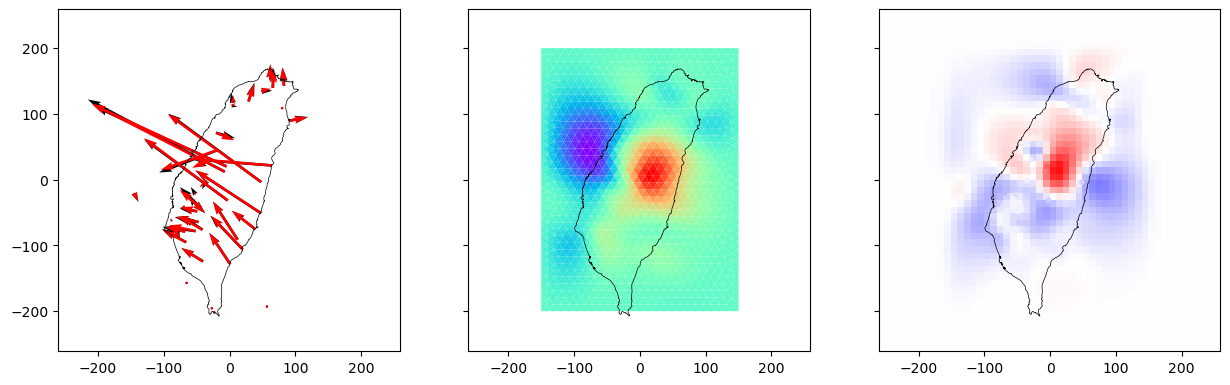

In [119]:
import matplotlib

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 15))
ax1.quiver(gps.x, gps.y, gps.e, gps.n, color='k', scale=500)
ax1.quiver(gps.x, gps.y, pred_disp[0::3], pred_disp[1::3], color='r', scale=500)
ax1.plot(coast[:, 0], coast[:, 1], 'k', linewidth=0.5)
ax1.set_aspect("equal")

plot_mesh(meshes[1], est_slip[1::3], ax2)
ax2.plot(coast[:, 0], coast[:, 1], 'k', linewidth=0.5)
ax2.set_aspect("equal")

plot_grid_x = Xg[0::gsubset, 0::gsubset]
plot_grid_y = Yg[0::gsubset, 0::gsubset]
plot_grid_z = horiz_pred_disp_grid[2::3].reshape(np.shape(plot_grid_x))
vert_disp_scale = 200
ax3.pcolormesh(plot_grid_x, plot_grid_y, plot_grid_z, shading="auto", cmap="bwr", vmin=-vert_disp_scale, vmax=vert_disp_scale)
ax3.scatter(gps.x, gps.y, s=10, c=gps.u, cmap="bwr", vmin=-vert_disp_scale, vmax=vert_disp_scale)
ax3.plot(coast[:, 0], coast[:, 1], 'k', linewidth=0.5)
ax3.set_aspect("equal")

plt.show()



## Coupled source-CMI slip model
Meant to mimic the coupled afterslip-viscoelastic model of Rousset et al.

In [105]:
import glob
import cutde.halfspace as cutde_halfspace
import numpy as np 

# Calculate partials for source fault
source_tri_pts = meshes[0].coords[meshes[0].verts]
n_source_tri = np.size(source_tri_pts, axis=0)
n_horiz_tri = np.size(horiz_tri_pts, axis=0)
n_tri = n_source_tri + n_horiz_tri
all_tri_pts = np.concatenate((source_tri_pts, horiz_tri_pts), axis=0)

# Calculate partial derivatives
# source_disp_mat = cutde_halfspace.disp_matrix(obs_pts=obsv, tris=source_tri_pts, nu=0.25)

# Concatenate partials
# all_disp_mat = np.concatenate((source_disp_mat, disp_mat), axis=2)

# Shift horizon down to 30 km
all_tri_pts[n_source_tri+1::, :, 2] -= 20
# all_disp_mat = cutde_halfspace.disp_matrix(obs_pts=obsv, tris=all_tri_pts, nu=0.25) 

# List of smoothing weights to test
smooths = [1e-6, 1e-2, 1e0]

# Assemble with smoothing
all_assembled_mat, all_weights = matrix_assembly(meshes, all_disp_mat, smoothing_weight=[smooths[1], smooths[1]])

# Indices to trim assembled design matrix and weights
source_row_start = np.size(obsv)
source_row_end = source_row_start + 3*n_source_tri
source_col_start = 0
source_col_end = 3*n_source_tri
horiz_row_start = source_row_end
horiz_row_end = horiz_row_start + 3*n_horiz_tri
horiz_col_start = source_col_end
horiz_col_end = horiz_col_start + 3*n_horiz_tri

# Remove tensile slip components from source fault only
all_assembled_mat = np.delete(all_assembled_mat, np.arange(2, source_col_end, 3), axis=1) # Columns
all_assembled_mat = np.delete(all_assembled_mat, np.arange(source_row_start+2, source_row_end, 3), axis=0) # Smoothing rows
all_weights = np.delete(all_weights, np.arange(source_row_start+2, source_row_end, 3), axis=0) # weights

# Update trim indices
source_row_start = np.size(obsv)
source_row_end = source_row_start + 2*n_source_tri
source_col_start = 0
source_col_end = 2*n_source_tri
horiz_row_start = source_row_end
horiz_row_end = horiz_row_start + 3*n_horiz_tri
horiz_col_start = source_col_end
horiz_col_end = horiz_col_start + 3*n_horiz_tri

# Calculate model covariance
all_cov = np.linalg.inv(all_assembled_mat.T * all_weights.T @ all_assembled_mat) 

# Allocate space for data vector
all_data_vector = np.zeros(np.size(all_assembled_mat, axis=0))

# Vector of displacements
all_data_vector[0:source_row_start] = disp_array.flatten()

# Estimate slip using pre-calculated covariance
all_est_slip = all_cov @ all_assembled_mat.T * all_weights.T @ all_data_vector 
# Predict displacement at station locations
all_pred_disp = all_assembled_mat[0:source_row_start, :].dot(all_est_slip)

# Predict displacement at surface grid stations, for comparison with publication visualizations
# all_disp_mat_grid = cutde_halfspace.disp_matrix(obs_pts=obsg, tris=all_tri_pts, nu=0.25)
all_disp_mat_grid_2d = all_disp_mat_grid.reshape((-1, 3*n_tri))
all_disp_mat_grid_2d = np.delete(all_disp_mat_grid_2d, np.arange(2, 3*n_source_tri, 3), axis=1) # Columns
all_pred_disp_grid = all_disp_mat_grid_2d.dot(all_est_slip)

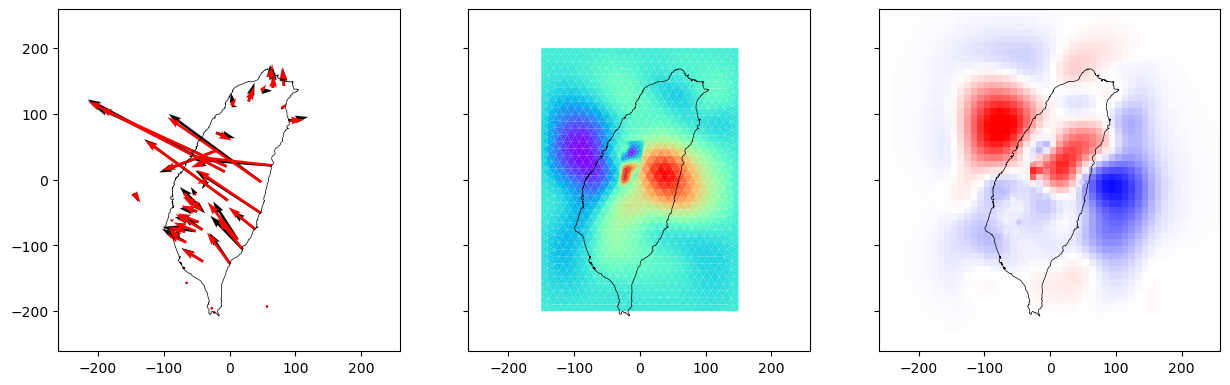

In [107]:
import matplotlib
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 15))
ax1.quiver(gps.x, gps.y, gps.e, gps.n, color='k', scale=500)
ax1.quiver(gps.x, gps.y, all_pred_disp[0::3], all_pred_disp[1::3], color='r', scale=500)
ax1.plot(coast[:, 0], coast[:, 1], 'k', linewidth=0.5)
ax1.set_aspect("equal")

plot_mesh(meshes[1], all_est_slip[2*n_source_tri+1::3], ax2)
plot_mesh(meshes[0], all_est_slip[1:2*n_source_tri:2], ax2)
ax2.plot(coast[:, 0], coast[:, 1], 'k', linewidth=0.5)
ax2.set_aspect("equal")

plot_grid_x = Xg[0::gsubset, 0::gsubset]
plot_grid_y = Yg[0::gsubset, 0::gsubset]
plot_grid_z = all_pred_disp_grid[2::3].reshape(np.shape(plot_grid_x))
vert_disp_scale = 200
ax3.pcolormesh(plot_grid_x, plot_grid_y, plot_grid_z, shading="auto", cmap="bwr", vmin=-vert_disp_scale, vmax=vert_disp_scale)
ax3.scatter(gps.x, gps.y, s=10, c=gps.u, cmap="bwr", vmin=-vert_disp_scale, vmax=vert_disp_scale)
ax3.plot(coast[:, 0], coast[:, 1], 'k', linewidth=0.5)
ax3.set_aspect("equal")
plt.show()

## Afterslip-only
Inverting onto just source geometry. Not quite the same as Rousset kinematic afterslip; their fault is larger, with a decollement

Info    : [ 60%] Clearing all models and views...
Info    : [ 60%] Done clearing all models and views
Info    : Writing 'chelungpu.geo_unrolled'...
Info    : Done writing 'chelungpu.geo_unrolled'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 0 (Line)
Info    : [ 20%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 5 (Line)
Info    : [ 80%] Meshing curve 6 (Line)
Info    : [ 90%] Meshing curve 7 (Line)
Info    : Done meshing 1D (Wall 0.000313625s, CPU 0.000303s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 60%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00392717s, CPU 0.003871s)
Info    : 248 nodes 516 elements
Info    : Writing 'chelungpu.msh'...
Info    : Done writing 'chelungpu.msh'


(-35.01637086598505, 29.840941885875935, -34.02617875990471, 58.64222201297112)

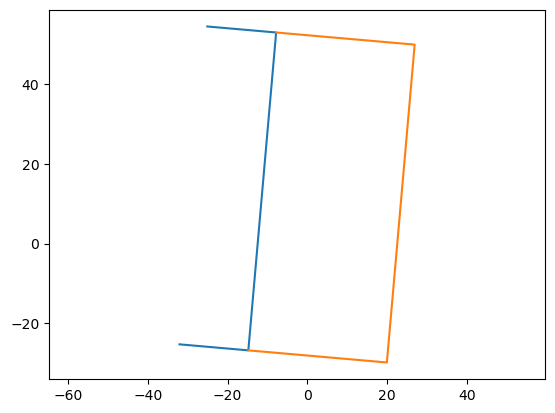

In [78]:
import gmsh
# Make Hsu et al. fault

# Digitized
corners = np.array(((-32.068311195445915, -25.265553869499243), (-25.237191650853887, 54.40060698027315), (27.514231499051235, 49.848254931714735), (19.924098671726753, -30.197268588770868)))
strike = np.arctan2(corners[1, 0]-corners[0, 0], corners[1, 1]-corners[0, 1])

# Approximated, using just SW corner and projecting
strike = np.deg2rad(5)
top_panel_width = 20
top_panel_dip = 30
top_panel_horiz = top_panel_width*np.cos(np.deg2rad(top_panel_dip))
top_panel_bot = top_panel_width*np.sin(np.deg2rad(top_panel_dip))
bot_panel_width = 35
bot_panel_dip = 5
bot_panel_horiz = bot_panel_width*np.cos(np.deg2rad(bot_panel_dip))
bot_panel_bot = bot_panel_width*np.sin(np.deg2rad(bot_panel_dip))
fault_length = 80

# Panel coordinates
top_panel_rect = np.array(((0, 0), (top_panel_horiz, 0), (top_panel_horiz, fault_length), (0, fault_length)))
bot_panel_rect = np.array(((0, 0), (bot_panel_horiz, 0), (bot_panel_horiz, fault_length), (0, fault_length)))

# Rotate by strike
top_panel_rect = np.array((np.cos(strike)*top_panel_rect[:, 0] + np.sin(strike)*top_panel_rect[:, 1], -np.sin(strike)*top_panel_rect[:, 0] + np.cos(strike)*top_panel_rect[:, 1])).T
bot_panel_rect = np.array((np.cos(strike)*bot_panel_rect[:, 0] + np.sin(strike)*bot_panel_rect[:, 1], -np.sin(strike)*bot_panel_rect[:, 0] + np.cos(strike)*bot_panel_rect[:, 1])).T

# Shift by SW corners
top_panel_rect = top_panel_rect + corners[0, :]
bot_panel_rect = bot_panel_rect + top_panel_rect[1, :]

# Add depths
top_panel_rect = np.hstack((top_panel_rect, np.array([[0], [top_panel_bot], [top_panel_bot], [0]])))
bot_panel_rect = np.hstack((bot_panel_rect, top_panel_bot + np.array([[0], [bot_panel_bot], [bot_panel_bot], [0]])))

# Create mesh
gmsh.initialize()
gmsh.clear()
# Define points
# From top
for i in range(4):
    gmsh.model.geo.addPoint(top_panel_rect[i, 0], top_panel_rect[i, 1], -top_panel_rect[i, 2], 5, i)
# From bottom
gmsh.model.geo.addPoint(bot_panel_rect[1, 0], bot_panel_rect[1, 1], -bot_panel_rect[1, 2], 5, 4)
gmsh.model.geo.addPoint(bot_panel_rect[2, 0], bot_panel_rect[2, 1], -bot_panel_rect[2, 2], 5, 5)
# Define lines
for i in range(3):
    gmsh.model.geo.addLine(i, i+1, i)
# Top edge
gmsh.model.geo.addLine(3, 0, i+1)
# Bottoms
gmsh.model.geo.addLine(1, 4, 5)
gmsh.model.geo.addLine(4, 5, 6)
gmsh.model.geo.addLine(5, 2, 7)
# Define curve loops
gmsh.model.geo.addCurveLoop(list(range(0, 4)), 1)
gmsh.model.geo.addCurveLoop((5, 6, 7, -1), 2)
# Surfaces
gmsh.model.geo.addPlaneSurface([1], 1)
gmsh.model.geo.addPlaneSurface([2], 2)
gmsh.model.geo.synchronize()
gmsh.write('chelungpu.geo_unrolled')
# Generate and write. Writing a file allows use of meshio, consistent with celeri codes
gmsh.model.mesh.generate(2)
gmsh.write("chelungpu.msh")
gmsh.finalize()

fig, ax = plt.subplots()
plt.plot(top_panel_rect[:, 0], top_panel_rect[:, 1])
plt.plot(bot_panel_rect[:, 0], bot_panel_rect[:, 1])
ax.axis("equal")

In [97]:
# Get matrices
import celeri 
import addict 

# Read and parse mesh
cmesh = []
cmesh.append(addict.Dict())
chmesh = meshio.read("chelungpu.msh")

# Assign into meshes dict 
cmesh[0].coords = chmesh.points
cmesh[0].verts = meshio.CellBlock("triangle", chmesh.get_cells_type("triangle")).data

cfault_pts = chmesh.points
cfault_tri = meshio.CellBlock("triangle", chmesh.get_cells_type("triangle")).data
cfault_tri_pts = cmesh[0].coords[cmesh[0].verts]

# Calculate partial derivatives
cdisp_mat = cutde_halfspace.disp_matrix(obs_pts=obsv, tris=cfault_tri_pts, nu=0.25)

# Get triangular smoothing matrix
smoothing_weight = 1e-2
operators = addict.Dict()
celeri.get_all_mesh_smoothing_matrices_simple(cmesh, operators)
ndisp_comp = np.size(cdisp_mat, axis=1)
nslip_comp = np.size(cdisp_mat, axis=3)

nobs = ndisp_comp*np.size(cdisp_mat, axis=0)
ntri = np.size(cdisp_mat, axis=2)

# Assemble matrices
chel_assembled_mat = np.zeros((nobs+nslip_comp*ntri, nslip_comp*ntri))
# Insert elastic partials
chel_assembled_mat[0:nobs, :] = cdisp_mat.reshape((-1, nslip_comp*ntri))
# Insert smoothing matrices
source_row_start = nobs
source_row_end = source_row_start + nslip_comp*ntri
chel_assembled_mat[source_row_start:source_row_end, 0:nslip_comp*ntri] = operators.smoothing_matrix[0].toarray()

# Assemble weighting vector
chel_weights = np.ones((np.shape(chel_assembled_mat)[0], 1))
chel_weights[source_row_start:source_row_end] = smoothing_weight

# Delete tensile slip components
chel_assembled_mat = np.delete(chel_assembled_mat, np.arange(2, 3*ntri, 3), 1) # Cut out tensile slip components
chel_assembled_mat = np.delete(chel_assembled_mat, np.arange(source_row_start+2, source_row_end, 3), 0) # Cut out tensile slip components from smoothing
chel_weights = np.delete(chel_weights, np.arange(source_row_start+2, source_row_end, 3))

# Calculate model covariance
chel_cov = np.linalg.inv(chel_assembled_mat.T * chel_weights.T @ chel_assembled_mat) 

# Allocate space for data vector
chel_data_vector = np.zeros(source_row_start+2*ntri)

# Vector of displacements
chel_data_vector[0:source_row_start] = disp_array.flatten()

# Estimate slip using pre-calculated covariance
chel_est_slip = chel_cov @ chel_assembled_mat.T * chel_weights.T @ chel_data_vector 
# Predict displacement at stations
cdisp_mat = chel_assembled_mat[0:nobs, :]
chel_pred_disp = cdisp_mat.dot(chel_est_slip)

# Predict displacement at surface grid stations, for comparison with publication visualizations
chel_disp_mat_grid = cutde_halfspace.disp_matrix(obs_pts=obsg, tris=cfault_tri_pts, nu=0.25)
chel_disp_mat_grid_2d = chel_disp_mat_grid.reshape((-1, 3*ntri))
chel_disp_mat_grid_2d = np.delete(chel_disp_mat_grid_2d, np.arange(2, 3*ntri, 3), axis=1) # Columns
chel_pred_disp_grid = chel_disp_mat_grid_2d.dot(chel_est_slip)

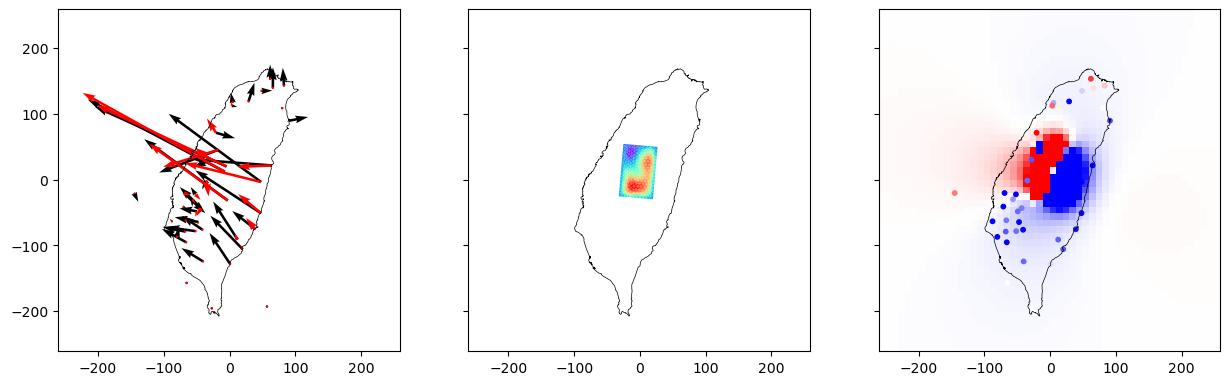

In [98]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 15))
plot_mesh(cmesh[0], chel_est_slip[1::2], ax2)
ax2.plot(coast[:, 0], coast[:, 1], 'k', linewidth=0.5)
ax2.set_aspect("equal")

ax1.quiver(gps.x, gps.y, gps.e, gps.n, color='k', scale=500)
ax1.quiver(gps.x, gps.y, chel_pred_disp[0::3], chel_pred_disp[1::3], color='r', scale=500)
ax1.plot(coast[:, 0], coast[:, 1], 'k', linewidth=0.5)
ax1.set_aspect("equal")

plot_grid_z = chel_pred_disp_grid[2::3].reshape(np.shape(plot_grid_x))
vert_disp_scale = 20
ax3.pcolormesh(plot_grid_x, plot_grid_y, plot_grid_z, shading="auto", cmap="bwr", vmin=-vert_disp_scale, vmax=vert_disp_scale)
ax3.scatter(gps.x, gps.y, s=10, c=gps.u, cmap="bwr", vmin=-vert_disp_scale, vmax=vert_disp_scale)
ax3.plot(coast[:, 0], coast[:, 1], 'k', linewidth=0.5)
ax3.set_aspect('equal')

plt.show()